In [1]:
import os
os.environ['SUMO_HOME'] = '/opt/homebrew/share/sumo'

In [2]:
import traci
from sumo_rl import SumoEnvironment

In [29]:
from stable_baselines3.common.callbacks import BaseCallback
import matplotlib.pyplot as plt

class StepCallback(BaseCallback):
    def __init__(self,max_episodes, verbose=0):
        super(StepCallback, self).__init__(verbose)
        self.max_episodes = max_episodes
        self.current_episode = 0
        self.episode_rewards = []
        self.current_episode_reward = 0
        self.episode_number = 0

    def _on_step(self) -> bool:
        # Get the reward for the current step
        rewards = self.locals["rewards"]
        self.current_episode_reward += rewards[0]

        # Check if the episode is done
        done_array = self.locals["dones"]
        if any(done_array):
            self.episode_rewards.append(self.current_episode_reward)
            self.episode_number += 1
            print(f"Episode {self.episode_number}: Total Reward = {self.current_episode_reward}")
            self.current_episode_reward = 0

        return self.current_episode < self.max_episodes

    def plot_rewards(self):
        plt.plot(self.episode_rewards)
        plt.xlabel("Episode")
        plt.ylabel("Total Reward")
        plt.title("Total Reward per Episode")
        plt.show()


In [15]:
from stable_baselines3 import DQN

In [25]:
steps_per_episode = 100000
number_of_episodes = 1
total_timesteps = steps_per_episode * number_of_episodes
def minimize_congestion_maximize_throughput_reward(traffic_signal):
    """
    Optimized reward function to maximize throughput while reducing congestion in all lanes.
    Args:
        traffic_signal (TrafficSignal): The traffic signal object.
    
    Returns:
        float: The calculated reward.
    """
    # Factor weights
    beta1, beta2, beta3, beta4, beta5, beta6, beta7 = -1, -0.1, -1, -0.5, 2, -0.01, -100

    # Total delays for all lanes (sum of delays across all lanes)
    delays = 0
    for lane in traffic_signal.lanes:
        avg_speed = traffic_signal.sumo.lane.getLastStepMeanSpeed(lane)
        speed_limit = traffic_signal.sumo.lane.getMaxSpeed(lane)
        lane_delay = 1 - avg_speed / speed_limit
        delays += lane_delay

    # Total waiting time for all lanes (sum of waiting times across all lanes)
    total_waiting_time = sum(traffic_signal.get_accumulated_waiting_time_per_lane())

    # Total queue length for all lanes (number of vehicles halted in all lanes)
    total_queue_length = traffic_signal.get_total_queued()

    # Phase change penalty
    phase_change = 1 if traffic_signal.is_yellow else 0

    # Total vehicles passing through the intersection (throughput)
    total_throughput = sum(traffic_signal.sumo.lane.getLastStepVehicleNumber(lane) for lane in traffic_signal.out_lanes)

    # Total travel time for vehicles passing through the intersection
    total_travel_time = sum(
        traffic_signal.sumo.vehicle.getWaitingTime(vehicle) for lane in traffic_signal.out_lanes
        for vehicle in traffic_signal.sumo.lane.getLastStepVehicleIDs(lane)
    )

    # Intersection blockage penalty based on pressure
    pressure = traffic_signal.get_pressure()
    blockage_penalty = beta7 if pressure > 0 else 0

    # Reward computation based on the weighted sum
    reward = (
        beta1 * delays +
        beta2 * total_waiting_time +
        beta3 * total_queue_length +
        beta4 * phase_change +
        beta5 * total_throughput +
        beta6 * total_travel_time +
        blockage_penalty
    )
    print(f"Reward: {reward}")

    return reward

env = SumoEnvironment(
    net_file="./environments/single-intersection.net.xml",
    route_file="./environments/single-intersection-vhvh.rou.xml",
    out_csv_name="./outputs/dqn",
    single_agent=True,
    reward_fn=minimize_congestion_maximize_throughput_reward,
    use_gui=True,
    num_seconds=steps_per_episode,  # Match num_seconds to total_timesteps
    begin_time=0
)

model = DQN(
    env=env,
    policy="MlpPolicy",
    learning_rate=0.0001,
    learning_starts=1000,
    train_freq=4,
    target_update_interval=1000,
    exploration_initial_eps=1.0,
    exploration_final_eps=0.01,
    exploration_fraction=0.1,
    verbose=1,
)

# Instantiate the callback
step_callback = StepCallback(verbose=1, max_episodes=number_of_episodes)
# Start training with the callback
model.learn(total_timesteps=total_timesteps, callback=step_callback)
step_callback.plot_rewards()



Initializing SumoEnvironment
 Retrying in 1 seconds
Step #0.00 (0ms ?*RT. ?UPS, TraCI: 7ms, vehicles TOT 0 ACT 0 BUF 0)                      
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Reset called, episode: 0
 Retrying in 1 seconds
Reward: -0.8451451979891967
Reward: -0.7738844880945759
Reward: 0.9240440125402314
Reward: -4.423204748519073
Reward: -4.8121382163484725
Reward: -6.319053400329274
Reward: -2.415140335929495
Reward: -4.311239394753272
Reward: -11.017911909226022
Reward: -18.816269344722656
Reward: -34.408767300693384
Reward: -46.54334954196975
Reward: -67.3283460638439
Reward: -69.53322698269466
Reward: -77.41759129715143
Reward: -90.77477389014527
Reward: -106.80429613113863
Reward: -109.53608407831035
Reward: -116.98715240582987
Reward: -136.42118830818382
Reward: -165.79069409773365
Reward: -189.7420253591184
Reward: -207.0283156406506
Reward: -204.0526971452492
Reward: -179.18722647093347
Reward: -169.00585525331198
Re

KeyboardInterrupt: 

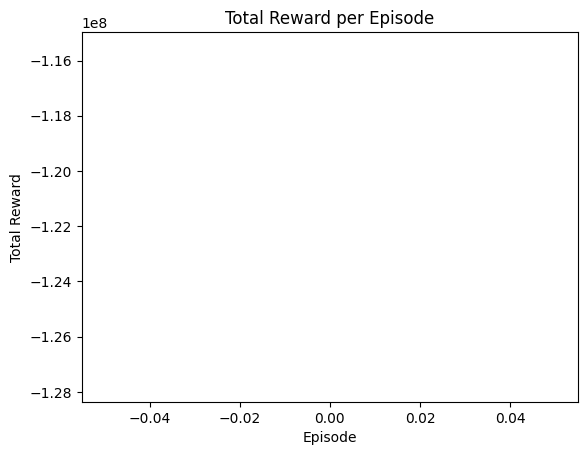

In [30]:
step_callback.plot_rewards()


In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# Path to the output directory
output_dir = './outputs'

# Iterate through each CSV file and create a graph for each episode
for filename in sorted(os.listdir(output_dir)):
    if filename.startswith('dqn_conn1_ep') and filename.endswith('.csv'):
        file_path = os.path.join(output_dir, filename)
        df = pd.read_csv(file_path)

        # Extract the episode number from the filename
        episode_num = filename.split('_ep')[1].split('.csv')[0]

        # Plot relevant graphs using the episode DataFrame
        plt.figure(figsize=(12, 8))

        # Plot system total stopped vehicles
        plt.subplot(2, 2, 1)
        plt.plot(df['step'], df['system_total_stopped'], color='blue')
        plt.title('System Total Stopped Vehicles (Episode {})'.format(episode_num))
        plt.xlabel('Time Step')
        plt.ylabel('Number of Vehicles')

        # Plot system total waiting time
        plt.subplot(2, 2, 2)
        plt.plot(df['step'], df['system_total_waiting_time'], color='green')
        plt.title('System Total Waiting Time (Episode {})'.format(episode_num))
        plt.xlabel('Time Step')
        plt.ylabel('Waiting Time')

        # Plot system mean waiting time
        plt.subplot(2, 2, 3)
        plt.plot(df['step'], df['system_mean_waiting_time'], color='orange')
        plt.title('System Mean Waiting Time (Episode {})'.format(episode_num))
        plt.xlabel('Time Step')
        plt.ylabel('Mean Waiting Time')

        # Plot system mean speed
        plt.subplot(2, 2, 4)
        plt.plot(df['step'], df['system_mean_speed'], color='red')
        plt.title('System Mean Speed (Episode {})'.format(episode_num))
        plt.xlabel('Time Step')
        plt.ylabel('Mean Speed')

        plt.tight_layout()
        plt.savefig(f'./outputs/episode_{episode_num}_graphs.png')
        plt.show()
